# An pictoral introduction to Gaussian processes and using them to calculate the Greeks

In [1]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar
from bokeh.palettes import Category10, Accent
output_notebook()

Loading BokehJS ...

## Gaussian processes
***

Gaussian processes are **distributions over functions** $f:\mathbb{R}^n \to \mathbb{R}$. Since a Gaussian is uniquely determined by its mean and covariance function, we consider its mean function $m:\mathbb{R}^n \to \mathbb{R}$ and *positive definite* covariance function $k:\mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R}$.

We write this mathematically as
$$f \sim \mathcal{GP}(m,k),$$

and require that, for any finite subset $X =\{\mathbf{x}_1 \ldots \mathbf{x}_n \}$ of the domain of $x$, the marginal distribution is a *multivariate Gaussian distribution*:

$$f(X) \sim \mathcal{N}(m(X), k(X, X))$$

with mean vector $\mathbf{\mu} = m(X)$ and covariance matrix $\Sigma = k(X, X)$.

**While the multivariate Gaussian caputures a finite number of jointly distributed Gaussians, the Gaussian process doesn't have this limitation.** Its mean and covariance are defined by a **function**. Each output of this function is a variable correlated with the other variables in the input domain, as defined by the covariance function. Since functions can have an infinite input domain, the Gaussian process can be interpreted as an infinite dimensional Gaussian random variable.

It is shown in Chapter 3.2 of [Dixon et al.](https://www.springer.com/gp/book/9783030410674) that the predictive
distribution of the Gaussian process evaluated at an arbitrary test point $x_*\in X_*$ is:

$$ f_* | X, Y, x_* \sim \mathcal{N}(\mathbb{E}[f_*| X,Y,x_*], \text{var}[f_*|X,Y,x_*]),$$
where 
\begin{align}\label{eq:asasa}
	\mathbb{E}[f_*| X,Y,x_*] =&~ \mu(X_*) + K_{X_*,X}[K_{X,X} + \sigma^2 I]^{-1} Y \qquad \qquad \qquad \qquad (1)
	\\
	\text{var}[f_*|X,Y,x_*] =&~ K_{X_*,X_*} - K_{X_*,X}[K_{X,X} + \sigma^2 I]^{-1}K_{X,X_*}. \qquad\qquad\qquad (2)
\end{align}

Here, $K_{X,X_*}$, $K_{X,X}$ etc, are matrices that consist of the kernel, $k$, evaluated at the corresponding points (in the first case, at $X$ and $X_*$).

## White Noise 
***
The simplest possible choice of covariance kernel $k$ is the (Kronecker) delta function $k (x_1,x_2) = \delta(||x_1 - x_2||) = \mathbb{1}_{\{x_1=x_2\}}$.

In this case 
$$ \begin{pmatrix} y_0 \\ \vdots\\y_n \end{pmatrix} \sim\mathcal{N}\left( \boldsymbol{0}, \boldsymbol{I_n}\right) $$

In [2]:
def plot_unit_gaussian_samples(D):
    p = figure(plot_width=800, plot_height=500, title='Samples from a unit {}D Gaussian'.format(D))

    xs = np.linspace(0, 1, D)
    for color in Accent[3]:
        ys = np.random.multivariate_normal(np.zeros(D), np.eye(D))
        p.line(xs, ys, line_width=1, color=color)
    return p

In [3]:
show(plot_unit_gaussian_samples(50))

This is just white noise! It seems unlikely that this is going to help us predict anything though... **We want something smoother.**

## The squared exponential kernel
***

We therefore consider the __squared exponential kernel__ which is defined by:

$$k(x_1, x_2) = \sigma^2\exp{ \left( -\frac{1}{2 l^2} \lVert x_1 - x_2 \rVert^2 \right)}$$

This function is 1 when $x_1=x_2$ and tends to zero as its arguments drift apart. 

In [4]:
def squared_exponential(xs, ys, sigma=1, l=1):
    """Squared Exponential kernel as above but designed to return the whole
    covariance matrix - i.e. the pairwise covariance of the vectors xs & ys.
    Also with two parameters which are discussed at the end."""

    # Pairwise difference matrix.
    dx = np.expand_dims(xs, 1) - np.expand_dims(ys, 0)
    return (sigma ** 2) * np.exp(-((dx / l) ** 2) / 2)

def m(x):
    """The mean function. We can let the mean always be zero."""
    return np.zeros_like(x)

In [5]:
N = 100
xs = np.linspace(-5, 5, N)
ys = [squared_exponential(np.array([0]),np.array([x])) for x in xs]

p = figure(plot_width=800, plot_height=500, x_axis_label='x', y_axis_label='k(x,0)', title='The squared exponential k(0,x)')
p.line(xs, ys, line_width=1)
show(p)

In [6]:
N = 100
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
d = squared_exponential(x, y)

color_mapper = LinearColorMapper(palette="Plasma256", low=0, high=1)

p = figure(plot_width=400, plot_height=400, x_range=(-2, 2), y_range=(-2, 2),
           title='Visualisation of k(x, x\')', x_axis_label='x', y_axis_label='x\'', toolbar_location=None)
p.image(image=[d], color_mapper=color_mapper, x=-2, y=-2, dw=4, dh=4)

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

show(p)

Now, let's try plotting some samples produced by the squared exponential kernel.

In [7]:
n = 100
xs = np.linspace(-5, 5, n)
K = squared_exponential(xs, xs, sigma=1, l=1)
mu = m(xs)

p = figure(plot_width=800, plot_height=500)
for color in Category10[5]:
    ys = np.random.multivariate_normal(mu, K)
    p.line(xs, ys, line_width=2, color=color)
show(p)

## The predictive distribution
***
Let's now try and use Gaussian process regression with the squared exponential kernel to fit a "hidden" function.

We take the hidden function to be a $5^{th}$ order polynomial:
$$f(x)=0.03 x^5 + 0.2 x^4 - 0.1 x^3 - 2.4 x^2 - 2.5 x + 6.$$

In [8]:
coefs = [6, -2.5, -2.4, -0.1, 0.2, 0.03]

def f(x):
    total = 0
    for exp, coef in enumerate(coefs):
        total += coef * (x ** exp)
    return total

In [9]:
xs = np.linspace(-5.0, 3.5, 100)
ys = f(xs)

p = figure(plot_width=800, plot_height=400, x_axis_label='x', y_axis_label='f(x)',
           title='The hidden function f(x)')
p.title.text_font_size = "15pt"
p.line(xs, ys, line_width=2)
show(p)

Let's suppose we observe the true function on some set $X = \{-4, -1.5, 0, 1.5, 2.5, 2.7\}$. Let's see how the Gaussian process fares over the unseen set $[-8,8]$. We make it a little larger to show that the Gaussian process with squared exponential kernel fares fairly poorly outside of seen values.

In [10]:
x_obs = np.array([-4, -1.5, 0, 1.5, 2.5, 2.7])
y_obs = f(x_obs)
x_s = np.linspace(-8,8, 500)

The covariance matrices $K_{X,X}$, $K_{X, X_*}$ and $K_{x_*,X_*}$ are given by:

In [11]:
K = squared_exponential(x_obs, x_obs)
K_s = squared_exponential(x_obs, x_s)
K_ss = squared_exponential(x_s, x_s)

Using the formulas in [Dixon et al.](https://www.springer.com/gp/book/9783030410674), and assuming the noiseless case, we find that

In [12]:
K_sTKinv = np.matmul(K_s.T, np.linalg.pinv(K))
mu_s = m(x_s) + np.matmul(K_sTKinv, y_obs - m(x_obs))
Sigma_s = K_ss - np.matmul(K_sTKinv, K_s)

We now plot the mean function along with 2 standard deviations of the posterior distribution.

In [13]:
def plot_regression_figure(x_obs,y_obs,x_s,y_true,stds,mu_s):
    p = figure(plot_width=800, plot_height=600, y_range=(-7, 8))
    p.line(x_s, y_true, line_width=3, color='black', alpha=0.7, line_dash='dashed', legend_label='True f(x)')
    p.cross(x_obs, y_obs, size=20, legend_label='Training data')
    err_xs = np.concatenate((x_s, np.flip(x_s, 0))) # concatenating x_s with x_s reversed...
    err_ys = np.concatenate((mu_s + 2 * stds, np.flip(mu_s - 2 * stds, 0)))
    p.patch(err_xs, err_ys, alpha=0.2, line_width=0, color='grey', legend_label='Uncertainty')
    p.line(x_s, mu_s, line_width=3, color='blue', alpha=0.4, legend_label='Mean')
    return p    

In [14]:
np.random.seed(42)
y_true = f(x_s)
stds = np.sqrt(Sigma_s.diagonal())
p = plot_regression_figure(x_obs,y_obs,x_s,y_true,stds,mu_s)
for count, color in enumerate(Category10[3]):
    y_s = np.random.multivariate_normal(mu_s, Sigma_s)
    p.line(x_s, y_s, line_width=1, color=color, legend_label=f"sample {count+1}")
show(p)

As we can see the prediction is poor outside of the range of the points seen. It is also worth noting that the variance of points that have not been seen converges to the *prior* $K_{X_*,X_*}$. This is just the parameter $\sigma$ of the squared exponential, which we have set to $1$.

Fitting a Gaussian kernel is done via maximizing the marginal likelihood  $p(\mathbf{y} \mid X, \theta)$ of the Gaussian process distribution based on the observed data $(X, \mathbf{y})$.

$$\hat{\theta}  = \underset{\theta}{\text{argmax}} \left( p(\mathbf{y} \mid X, \theta) \right)$$

The marginal likelihood of the Gaussian process is the likelihood of a Gaussian distribution which is defined as:

$$p(\mathbf{y} \mid \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^n \lvert\Sigma\rvert}} \exp{ \left( -\frac{1}{2}(\mathbf{y} - \mu)^{\top} \Sigma^{-1} (\mathbf{y} - \mu) \right)}$$

The mean and covariance are calulated from their parameterized functions using the observed data $X$ as input: $\mu_{\theta} = m_{\theta}(X)$ and $\Sigma_{\theta} = k_{\theta}(X, X)$, so we can write the marginal likelihood as:

$$
p(\mathbf{y} \mid X, \theta) =
\frac{1}{\sqrt{(2\pi)^n \lvert \Sigma_{\theta} \rvert}} \exp{ \left( -\frac{1}{2}(\mathbf{y} - \mu_{\theta})^\top \Sigma_{\theta}^{-1} (\mathbf{y} - \mu_{\theta}) \right)}$$

With $n$ the dimensionality of the marginal and $\lvert \Sigma_{\theta} \rvert$ the deteriminant of the kernel matrix. We can get rid of the exponent by taking the log and maximizing the log marginal likilihood:

$$ \log{p(\mathbf{y} \mid X, \theta)} =
-\frac{1}{2}(\mathbf{y} - \mu_{\theta})^\top \Sigma_{\theta}^{-1} (\mathbf{y} - \mu_{\theta}) - \frac{1}{2} \log{\lvert \Sigma_{\theta} \rvert} - \frac{n}{2} \log{2 \pi}$$

The first term ($-\frac{1}{2} (\mathbf{y} - \mu_{\theta})^\top \Sigma_{\theta}^{-1} (\mathbf{y} - \mu_{\theta})$) is the data-fit while the rest ($-\frac{1}{2}(\log{\lvert \Sigma_{\theta} \rvert} + n\log{2 \pi})$) is a complexity penalty, also known as [differential entropy](https://en.wikipedia.org/wiki/Differential_entropy)[⁽¹⁾](#Sidenotes).



The optimimal parameters $\hat{\theta}$ can then be found by minimizing the negative of the log marginal likilihood:

$$
\hat{\theta}  = \underset{\theta}{\text{argmax}} \left( p(\mathbf{y} \mid X, \theta) \right) = \underset{\theta}{\text{argmin}} { \;-\log{ p(\mathbf{y} \mid X, \theta)}}$$

In practice, this is done via numerical methods. We do not code this up, but instead leverage the scikit-learn Gaussian process functionality to fit the model to data. 

## Using Scikit-learn
*** 

In this section we repreoduce the above, using Scikit-learn instead of first principles. We then use the optimisation functionality of sklearn to tune the hyper-parameters of our kernel and get a better fit.

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

The `scikit-learn` API is very consistent across learning methods, and as a result, all functions expect a tabular set of input variables, either as a 2-dimensional NumPy `array` or a pandas `DataFrame`. Since we have only a single input variable here, we can add a second dimension using the `reshape` method:

In [16]:
X_obs= x_obs.reshape(-1, 1)
Y_obs = y_obs.reshape(-1,1)
X_s = x_s.reshape(-1,1)
Y_s = y_true.reshape(-1,1)
X_obs.shape

(6, 1)

In [17]:
kernel = RBF(length_scale=1.0, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_obs,Y_obs)
Y_pred, Sigma_pred = gp.predict(X_s, return_std=True)

In [18]:
y_pred = Y_pred.reshape(1,500)[0]
sigma_pred = Sigma_pred.reshape(1,500)[0]

np.random.seed(42)
p = plot_regression_figure(x_obs,y_obs,x_s,y_true,sigma_pred,mu_s)
p.title.text = f"The fitted Gaussian process regressor with {kernel} kernel"
p.title.align = "center"
p.title.text_font_size = "20px"
for count, color in enumerate(Category10[3]):
    y_s = gp.sample_y(X_s, random_state=count).reshape(1,len(X_s))[0]
    p.line(x_s, y_s, line_width=1, color=color, legend_label=f"sample {count+1}")
show(p)

### ... Now we optimise our kernel

In [19]:
N = 1000
xs = np.linspace(-10, 10, N)
p = figure(plot_width=800, plot_height=500, x_axis_label='x', y_axis_label='k(0,x)', title='The squared exponential k(0,x)',
          y_range=(-.1,1.2))

ls = [0.2,1,5]

for count, color in enumerate(Category10[3]):
    ys = [squared_exponential(np.array([0]),np.array([x]), l=ls[count]) for x in xs]
    p.line(xs, ys, line_width=1, color=color, legend_label=f"l = {ls[count]}")   

show(p)

In [20]:
p = figure(plot_width=800, plot_height=600, y_range=(-7, 8),title='Different values of l')
p.title.text_font_size = "15pt"
for count, color in enumerate(Category10[4]):
    l = 10**(count-1)
    kernel = RBF(length_scale=l, length_scale_bounds="fixed")
    gp = GaussianProcessRegressor(kernel=kernel)
    y_s = gp.sample_y(X_s, random_state=count).reshape(1,len(X_s))[0]
    p.line(x_s, y_s, line_width=1, color=color, legend_label=f"l = {l}")   
show(p)

In [21]:
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_obs,Y_obs)
Y_pred, Sigma_pred = gp.predict(X_s, return_std=True)
np.random.seed(42)
p = plot_regression_figure(x_obs,y_obs,x_s,y_true,sigma_pred,mu_s)
p.title.text = f"The fitted Gaussian process regressor with {gp.kernel_} kernel"
p.title.align = "center"
p.title.text_font_size = "20px"
for count, color in enumerate(Category10[3]):
    y_s = gp.sample_y(X_s, random_state=count).reshape(1,len(X_s))[0]
    p.line(x_s, y_s, line_width=1, color=color, legend_label=f"sample {count+1}")
show(p)

In [22]:
print(f"We see here that our fit is much the same as for when l=1. In fact our optimal value is {gp.kernel_}")

We see here that our fit is much the same as for when l=1. In fact our optimal value is RBF(length_scale=0.759)


## Changing the Kernel
***

Based on [this article.](https://www.cs.toronto.edu/~duvenaud/cookbook/)

# Calculating the Greeks
***

In what follows, European option prices are generated from the Black-Scholes model.  We begin by building a GP call model, where the input is the underlying price. The delta is then derived and compared with the Black-Scholes (BS)
delta. The exercise is repeated, but using the volatility as the input instead of the underlying price. The vega of the GP is then derived and compared with the BS vega.

In [23]:
import sys
if "../" not in sys.path:
    sys.path.append("../")
    
from BlackScholes import bsformula

import numpy as np
import scipy as sp

from sklearn import gaussian_process
import matplotlib.pyplot as plt
%matplotlib inline

## Black-Scholes Model
***
First, set the model parameters

In [24]:
KC = 130    # Call strike
KP = 70     # Put strike
r = 0.002   # risk-free rate
sigma = 0.4 # implied volatility
T = 2.0     # Time to maturity
S0 = 100    # Underlying spot

In [25]:
lb = 0   # lower bound on domain
ub = 300 # upper bound on domain
training_number = 100 # Number of training samples
testing_number = 500   # Number of testing samples
sigma_n = 1e-8 # additive noise in GP

Define the call and put prices using the BS model


In [26]:
bsformula?

In [27]:
call = lambda price, vol: bsformula(1, lb+(ub-lb)*price, KC, r, T, vol, 0)[0]
put = lambda price, vol: bsformula(-1, lb+(ub-lb)*x, KP, r, T, vol, 0)[0]

## Delta
***

The Delta ($\Delta$) of an option is the first derivative of the option value with respect to the underlying asset price. 
If we hold $-\Delta$ units of the asset (to every 1 unit of the option), we are in a delta neutral position. This means that if we are in a Black - Merton - Scholes financial market (fixed volatility) then price changes of the underlying asset do not matter and we have perfectly hedged away our risk. It is therefore a very useful quantity to know. Furthermore, even if we want to calculate more complicated hedging strategies, a delta-gamma hedge for example, then we need to know the delta.

How do we calculate the delta of an option?

We are going to use equation (1). If we take the derivative of equation (1) at a point $X_*$ we get 

\begin{align}
	\frac{\partial}{\partial X_*}\mathbb{E}[f_*| X,Y,x_*] =&~ \frac{\partial}{\partial X_*}\mu(X_*) + \left(\frac{\partial}{\partial X_*} K_{X_*,X}\right) [K_{X,X} + \sigma^2 I]^{-1} Y, 
    \\
    \text{where } \left(\frac{\partial}{\partial X_*} K_{X_*,X}\right)=&~ \frac{1}{l^2} (X- X_*) K_{X_*,X}.
\end{align}
Note that $\alpha = [K_{X,X} + \sigma^2 I ]$ is already calculated at training time (for pricing) by Cholesky matrix factorization with $O(n^3)$ complexity, so there is no significant computational overhead from Greeking.

1. Generate the training and testing data, where the input is the gridded underlying and the output are the option prices. 

In [28]:
x_train = np.array(np.linspace(0.01, 1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01, 1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
for idx in range(len(x_train)):
    y_train.append(call(x_train[idx], sigma))
y_train = np.array(y_train)

2. Fit the GP model to the generated data

In [29]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20, normalize_y=True) 
gp.fit(x_train, y_train)   # Here, n_restarts > 1 means we keep restarting the algo. This helps avoid local optima.

C:\Users\Josep\anaconda3\envs\computational-finance\lib\site-packages\sklearn\gaussian_process\_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20,
                         normalize_y=True)

3. Get the model's predicted outputs for each of the test inputs

In [30]:
y_pred, sigma_hat = gp.predict(x_test, return_std=True)

C:\Users\Josep\anaconda3\envs\computational-finance\lib\site-packages\sklearn\gaussian_process\_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4. Derive the GP delta

In [31]:
l = gp.kernel_.length_scale
rbf = gaussian_process.kernels.RBF(length_scale=l)
Kernel = rbf(x_train, x_train) # Calculate K_{X,X}

In [32]:
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)  # Computes the Cholesky decomposition, the matric L s.t. L L* = A
alpha = sp.linalg.cho_solve(np.transpose(L), y_train) # Solve the linear equations A x = y_train, 
                                                        # given the Cholesky factorization of A.

C:\Users\Josep\anaconda3\envs\computational-finance\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [33]:
k_s = rbf(x_test, x_train)     # Calculate K_{X,X_*}
k_s_prime = (x_train.T - x_test) * k_s / l**2  # This is just the partial derivative of K_{X,X_*} w.r.t X_*
gp_delta_vec = np.dot(k_s_prime, alpha) / (ub - lb) 

5. Compare the GP delta with the BS delta

In [34]:
delta = lambda x, y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[1]

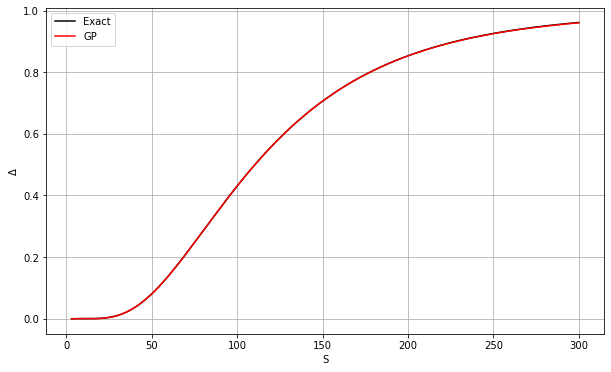

In [35]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma), color = 'black', label = 'Exact')
plt.plot(lb+(ub-lb)*x_test, gp_delta_vec, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('$\Delta$')
plt.legend(loc = 'best', prop={'size':10});

6. Show the error between the GP delta and the BS delta

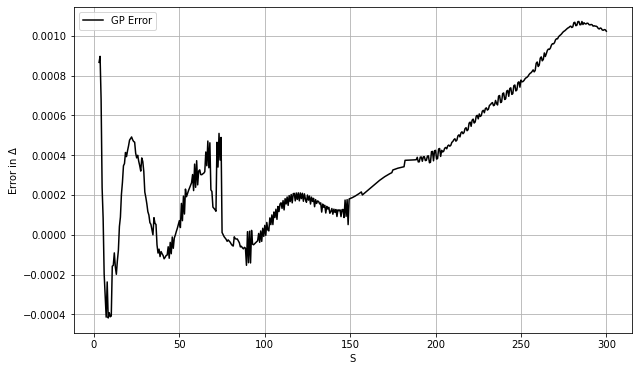

In [36]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma) - gp_delta_vec, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('Error in $\Delta$')
plt.legend(loc = 'best', prop={'size':10});

**This is insanely good. We have 10 data points, and the error is essentially zero. The exception is at the lower end, outside the scope of seen data points.**

## Gamma
***


Gamma, $\Gamma$, measures the rate of change in the delta with respect to changes in the underlying price. Gamma is the second derivative of the value function with respect to the underlying price.

Similarly to before, we take the second derivative of the posterior mean with respect to $X_*$. This gives us
\begin{align}
	\frac{\partial^2}{\partial X_*^2}\mathbb{E}[f_*| X,Y,x_*] = \frac{1}{l^2} \left(\frac{(X- X_*)^2}{l^2} - \boldsymbol{1} \right) K_{X_*,X}.
\end{align}

In [40]:
k_s_double_prime = ((x_train.T - x_test)**2 / l**2 - np.ones_like(x_test))* k_s / l**2

In [41]:
gp_gamma_vec = np.dot(k_s_double_prime, alpha) / (ub - lb) 

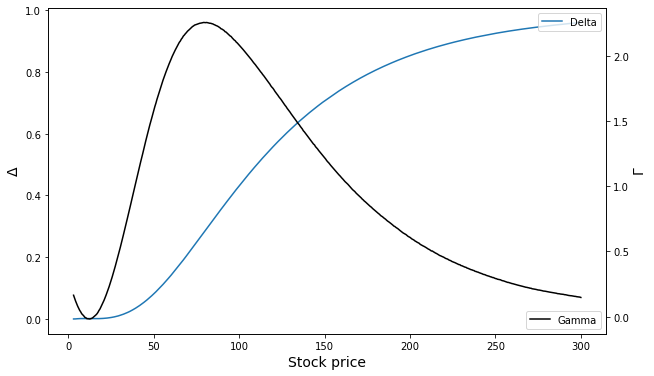

In [42]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (10,6),facecolor='white', edgecolor='black')
# make a plot
ax.plot(lb+(ub-lb)*x_test, gp_delta_vec, label = 'Delta')
# set x-axis label
ax.set_xlabel("Stock price",fontsize=14)
# set y-axis label
ax.set_ylabel('$\Delta$',fontsize=14)
plt.legend(loc = 'upper right', prop={'size':10});
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(lb+(ub-lb)*x_test, gp_gamma_vec, color = 'black', label = 'Gamma')
ax2.set_ylabel("$\Gamma$",color="black",fontsize=14)
plt.legend(loc = 'lower right', prop={'size':10});
plt.show()

## Vega
***
Vega measures sensitivity to volatility. Vega is the derivative of the option value with respect to the volatility of the underlying asset.

We now calculate the vega. This is exactly the same formula as for delta, except for the fact that we fit the GP to the data observed at different values of the volatility $\sigma$.

1. Generate the training and testing data, where the input is the gridded underlying and the output are the option prices. The inputs are again scaled to the unit domain. 

In [56]:
x_train = np.array(np.linspace(0.01, 1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01, 1.0, testing_number), dtype='float32').reshape(testing_number, 1)
y_train = []
for idx in range(len(x_train)):
    y_train.append(call((S0-lb)/(ub-lb), x_train[idx]))
y_train = np.array(y_train)

2. Fit the GP model to the generated data

In [57]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20, normalize_y=True)
gp.fit(x_train, y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20,
                         normalize_y=True)

3. Get the model's predicted outputs for each of the test inputs

In [58]:
y_pred, sigma_hat = gp.predict(x_test, return_std=True)

C:\Users\Josep\anaconda3\envs\computational-finance\lib\site-packages\sklearn\gaussian_process\_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4. Derive the GP vega

In [59]:
l = gp.kernel_.length_scale
rbf = gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha = sp.linalg.cho_solve(np.transpose(L), y_train)    
k_s = rbf(x_test, x_train)

C:\Users\Josep\anaconda3\envs\computational-finance\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [60]:
# k_s_prime = np.zeros([len(x_test), len(x_train)])
# for i in range(len(x_test)):
#     for j in range(len(x_train)):
#         k_s_prime[i, j] = (1.0/l**2) * (x_train[j] - x_test[i]) * k_s[i, j]       
        
k_s_prime = (x_train.T - x_test) * k_s / l**2
gp_vega_vec = np.dot(k_s_prime, alpha)

5. Calculate the BS vega

In [61]:
vega = lambda x, y: bsformula(1, lb + (ub-lb) * x, KC, r, T, y, 0)[2]

6. Compare the GP vega with the BS vega

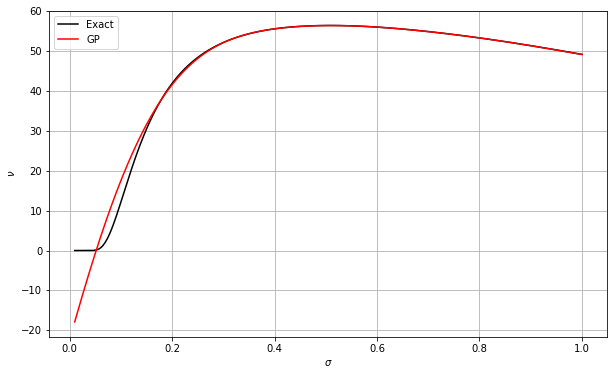

In [62]:
plt.figure(figsize = (10,6), facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test), color = 'black', label = 'Exact')
plt.plot(x_test, gp_vega_vec, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('$\\nu$')
plt.legend(loc = 'best', prop={'size':10});

7. Plot the error between the GP vega and the BS vega

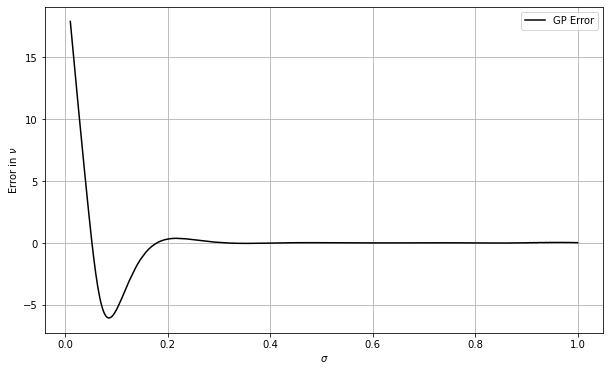

In [64]:
plt.figure(figsize = (10,6), facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test)-gp_vega_vec, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('Error in $\\nu$')
plt.legend(loc = 'best', prop={'size':10});

## Resources
***
A lovely interactive explanation of Gausian processes: https://distill.pub/2019/visual-exploration-gaussian-processes/

Model comparison: https://ned.ipac.caltech.edu/level5/Sept13/Trotta/Trotta4.html